# Moving from standard to stream learning

This tutorial is inspired by the [river library](https://riverml.xyz) examples and recipies. So, a closer look to those ones is encorage to any person who want to indepth on this particular topics.

Generaly speaking, nearly any approach in machine learning can be summarize in the following steps:

1. Defining the problem
    1. Identify the kind of problem (supervised vs un supervised, classification vs regression, etc.)
1. Loading the data
2. Preprocessing that data
    1. Feature extraction
    2. Feature selection
3. Fitting the model
    1. Ajusted the hyperparameters
4. Evaluate the model according certain measures

Let's see a classical example which ticks all those steps

In [38]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from rich import print


# Load the data
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

# Prepare the pipeline with the preprocessing steps and the model to be used
pipe = Pipeline([
    ('scale', StandardScaler()),                       # Prepapare the data centered in avg 0 and std 1
    ('extractor', PCA(0.95)),                          # Extract features that represents 0.95 of the variability
    ('classifier', LogisticRegression(solver='lbfgs')) # Last step the model to perform the classificaction
])

# Define a determistic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate the performance for each fold of the cross valiada
scorer = make_scorer(roc_auc_score)
scores = cross_val_score(pipe, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.9776 (± 0.0165)

So, what is the problem with this approach, it has no problem but some downsize can be detected. First and foremost, if the data returned by `load_breast_cancer` had been too big for the memory of your computer, the program would have crashed. Although some techniques can be applied to minimize this threat, such as optimizing the typing, or the use of sparse storage for the data there is a limit to the optimizations available. If your dataset potentially can have millions of samples which can weigh hundreds of gigabytes, you will need some special hardware for sure. One solution is to do out-of-core learning; that is, algorithms that can learn by being presented the data in chunks or mini-batches, but potential issues arise from these considering the order and the local minima of the search space.

Another potential issue is the incorporation of new data into the model. Traditional approaches require starting from scratch with a new dataset result of the combination of the old data with the new samples available. This is particularly problematic in real-time applications where you have new data available now and then. In many real applications, the solution is to perform a continuous integration pipeline which can deploy a new model nearly several times per minute.

Finally, another problem of the traditional approach is the availability of the features. Some features might not be accessible at the particular point in time you are at, for example, a particular state of an object or an amount at a warehouse is not available in a week or month because the data is updated.

# Incremental learning

Incremental learning is also called online learning or stream learning, however, if you google "online learning", it is unlikely that the results are what you were looking for. Consequently, the terms "incremental learning" and "stream learning" are usually preferred. Behind incremental learning is a very clear idea which it is is to fit a model according to a continuous stream of data. In other words, the data isn't available in its entirety, but rather the observations are provided one by one. For example, imagine the previous classical example which, instead of the data set, we have a reference point providing one sample at a time. This can be simulated with a simple loop, such as:

In [5]:
for xi, yi in zip(X, y):
    pass

Since the data is already in memory, this is not the ideal scenario to exemplify it. However, keep in mind that in this particular case we are using each sample a single time. This can also be used in the same way by iterating on the results from a CSV file, a Kafka stream, an SQL query, etc.

One particular point to be aware of is the fact that in this example `xi` is an instance of `numpy.array`. By its design, the library that we are using, `river`, uses the class `dict` as the base of its behaviour. The authors of the library assume a point of view where each observation represents a single sample which could make sense from the point of view of a stream of data. It is no limitation but something to be aware of when performance is required. Remember that `dict` is implemented in **Python**, while the `numpy.array` is implemented at a low level in **C** and **Fortran**. One of the advantages of using `dict` is easy access to the features and a clearer program.

In [6]:
print(f"In numpy.array format:{xi}\n")
print(f"In dict format: {dict(zip(dataset.feature_names, xi))}")

In numpy.array format:[7.760e+00 2.454e+01 4.792e+01 1.810e+02 5.263e-02 4.362e-02 0.000e+00
 0.000e+00 1.587e-01 5.884e-02 3.857e-01 1.428e+00 2.548e+00 1.915e+01
 7.189e-03 4.660e-03 0.000e+00 0.000e+00 2.676e-02 2.783e-03 9.456e+00
 3.037e+01 5.916e+01 2.686e+02 8.996e-02 6.444e-02 0.000e+00 0.000e+00
 2.871e-01 7.039e-02]

In dict format: {'mean radius': 7.76, 'mean texture': 24.54, 'mean perimeter': 47.92, 'mean 
area': 181.0, 'mean smoothness': 0.05263, 'mean compactness': 0.04362, 'mean concavity': 0.0,
'mean concave points': 0.0, 'mean symmetry': 0.1587, 'mean fractal dimension': 0.05884, 
'radius error': 0.3857, 'texture error': 1.428, 'perimeter error': 2.548, 'area error': 
19.15, 'smoothness error': 0.007189, 'compactness error': 0.00466, 'concavity error': 0.0, 
'concave points error': 0.0, 'symmetry error': 0.02676, 'fractal dimension error': 0.002783, 
'worst radius': 9.456, 'worst texture': 30.37, 'worst perimeter': 59.16, 'worst area': 268.6,
'worst smoothness': 0.08996, 'worst compactness': 0.06444, 'worst concavity': 0.0, 'worst 
concave points': 0.0, 'worst symmetry': 0.2871, 'worst fractal dimension': 0.07039}

Although it is not complicated, `river` provides a convinient function to transform the datasets from `scikit-learn`to the required format. For the examples developed in this notebook, you can use the following

In [7]:
from river import stream
for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    pass

Therefore, the change in our code seems pretty focalized and not quite important. By simply changing our well-known batches by the stream of data a lot of things cannot be done in the same way. For example, something so trivial and commonly done such as the standardisation of the data, i.e. scaling the data to have mean 0 and variance 1. This simple operation in the batched approach changes into something more complicated in the stream data because we don't know the values of the mean and the standard deviation before actually going through all the data. For this problem, a possible approach is to perform the first pass over the data to compute the necessary values and then scale the values during a second pass. However, this approach goes against out objective of only looking at the data once and many times it is not possible. So, how we can solve this, the answer comes in the shape o what is called computing running statistics or moving statistics. By using those we do not use the exact mean and standard deviation but an estimation which can be updated with each new value. For example, denoting the mean as $\mu_t$ and the count of element at any moment $n_t$, the mean can be easily updated at any moment by applying the following function:
$$
  n_{t+1} = n_t +1 \\    
  \mu_{t+1} = \mu_t +\frac{x - \mu_t}{n_{t+1}}    
$$

In the same way, for the variance($\sigma$), the previous formula can be completed with:
$$
  s_{t+1} = s_t + (x-\mu_t)\times(x-\mu_{t+1})\\
  \sigma_{t+1} = \frac{s_{t+1}}{n_{t+1}}
$$

where $s_t$  is a running sum of squares and $\sigma_t$ is the running variance at time $t$. These four formulae can be easily rewritten in Python for example, take the `mean radius` as our Guinea Pig:

In [10]:
#Let's inicialize the variables before any rolling calculation
n, mean, s, variance = 0, 0, 0, 0

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    n += 1
    mean_t = mean
    mean += (xi['mean radius'] - mean) / n
    s += (xi['mean radius'] - mean_t) * (xi['mean radius'] - mean)
    variance = s / n

print(f'Running mean: {mean:.3f}')
print(f'Running variance: {variance:.3f}')

Running mean: 14.127

Running variance: 12.397

Now, compare the results with the ones implementations of `numpy`. 

In [11]:
import numpy as np

i = list(dataset.feature_names).index('mean radius')
print(f'True mean: {np.mean(X[:, i]):.3f}')
print(f'True variance: {np.var(X[:, i]):.3f}')

True mean: 14.127

True variance: 12.397

The results are identical with a key difference, the `numpy`implementation requires all data to be available for the calculation while the another is calculated as the problem progress in its development. Therefore, we should keep in mind that the results with a few instances are not going to be very accurate. 

SO, once we can calculate different statistics on the data, the next step is to use those in order to normalize or standarize the data in a similar way as the batched approach. In `river`, several functions has been implemented in this sense in the `preprocessing` module. For example, to standarize all the features of the previous example we can perform:

In [30]:
from river.preprocessing import StandardScaler

scaler = StandardScaler()

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    scaler = scaler.learn_one(xi)

So, now that we are scaling the data, we can step forward and perform some machine learning approach. In this example, we are going to implement a linear regression based on an *stochastic gradient descent (SGD)*. The idea behind it is to optimize the output of the linear regression based on the maximum variance of the error made between the prediction and the true output. In this particular case, the *Squared Error* is the loss function in order to elude possible compensations due to signal change.

In [16]:
from river.linear_model import LogisticRegression
from river.optim import SGD

scaler = StandardScaler()
optimizer = SGD(lr=0.01)
log_reg = LogisticRegression(optimizer)

y_true = []
y_pred = []

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer(), shuffle=True, seed=42):

    # Scale the features
    xi_scaled = scaler.learn_one(xi).transform_one(xi)

    # Test the current model on the new "unobserved" sample
    yi_pred = log_reg.predict_proba_one(xi_scaled)
    # Train the model with the new sample
    log_reg.learn_one(xi_scaled, yi)

    # Store the truth and the prediction
    y_true.append(yi)
    y_pred.append(yi_pred[True])

print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.4f}')

ROC AUC: 0.9896

The results seem to be a little better than the ones from `scikit-learn`. Let's make a proper comparison, to do that, we should use the same CV folds ffor each approach and compaare the results. Although, we could define the same process quite easily, in order to make them completely comparable, `river` provides a module called `compat` which improves the compatibility with other Python libreries such as skelearn. So, we can use the function `convert_river_to_sklearn` to obtain an object perfectly compatible with the functions of `scikit-learn`.

In [36]:
from river.compose import Pipeline
from river.compat import convert_river_to_sklearn


# We define a Pipeline, becasuse we need a single object 
model = Pipeline(
    ('scale', StandardScaler()),
    ('ml_model', LogisticRegression())
)

# This funtion returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

# Now, we can proceed using the cross_val_score from 
# sklearn with the River wrapped model
scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)

# Let's compare the results
print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.9639 (± 0.0158)

Although they are lower than the previous test, the results are comparable to the batch learning approach. 

# Pipelines

Although it has been barely introduce in the previous section, many times the "flow" of information in a machine learning approach can be modeled as a sequence of steps. In order to perform this operation, some libreries such as `scikit=learn` or `pandas` have the definition of objects to contain this type of definition. 

However, in practice, you are going to see very few use of the pipes because, for most developers, it is easier to think their workflows in a procedural way instead of a declarative one. The main reason is due to the mayority of batch machine learning, however, when wetalk about online learning, pipelines seems the more natural way to reason. Let's compare the same process perform with a procedural approach and with a declarative one which is based on pipelines.

Now we are going to change the problem for one of Kaggle Competitions. 

In [18]:
from rich import print
from river.datasets import Restaurants

data = Restaurants()

print(data)

Data from the Kaggle Recruit Restaurants challenge.

The goal is to predict the number of visitors in each of 829 Japanese restaurants over a 
priod
of roughly 16 weeks. The data is ordered by date and then by restaurant ID.

      Name  Restaurants                                                               
      Task  Regression                                                                
   Samples  252,108                                                                   
  Features  7                                                                         
    Sparse  False                                                                     
      Path  /home/quique/river_data/Restaurants/kaggle_recruit_restaurants.csv        
       URL  https://maxhalford.github.io/files/datasets/kaggle_recruit_restaurants.zip
      Size  27.54 MB                                                                  
Downloaded  False

Lets check the structure of the data:

In [19]:
print(next(iter(data)))

Uncompressing into /home/quique/river_data/Restaurants


(
    {
        'store_id': 'air_04341b588bde96cd',
        'date': datetime.datetime(2016, 1, 1, 0, 0),
        'is_holiday': True,
        'genre_name': 'Izakaya',
        'area_name': 'Tōkyō-to Nerima-ku Toyotamakita',
        'latitude': 35.7356234,
        'longitude': 139.6516577
    },
    10
)

Lets bwgging with the procedural approach 

In [20]:
from river import feature_extraction, linear_model, metrics, preprocessing, stats, utils

# Let's create the average of the last 7, 14 and 21 days
features = (
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)),
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)),
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21))
)

scaler = preprocessing.StandardScaler()
model = linear_model.LinearRegression()
metric = metrics.MAE()

for x, y in data:

    # Derive date features
    x['weekday'] = x['date'].weekday()
    x['is_weekend'] = x['date'].weekday() in (5, 6)

    # Process the rolling means of the target  
    for mean in features:
        x = {**x, **mean.transform_one(x)}
        mean.learn_one(x, y)

    # Remove the key/value pairs that aren't features
    for key in ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']:
        x.pop(key)

    # Rescale the data
    x = scaler.learn_one(x).transform_one(x)

    # Fit the linear regression
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)

print(metric)

MAE: 8.316538

In [21]:
#check the last sample
print(x)

{
    'is_holiday': -0.23103573677646685,
    'weekday': 1.0292832579142892,
    'is_weekend': 1.6249280076334165,
    'y_mean_by_store_id': -1.3980979075298516
}

Now, lets rewrite the same code but with an approach more declarative based on the steps od the pipeline

In [22]:
from river import compose

# funtion to transform the data in the same features used previously
def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}

# Build the pipeline with the same steps that has been previously done
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7))),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14))),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)))
    )),
    ('drop_non_features', compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

metric = metrics.MAE()

for x, y in data:

    # Make a prediction without using the target
    y_pred = model.predict_one(x)

    # Update the model using the target
    model.learn_one(x, y)

    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)

print(metric)


MAE: 8.41379

As you can see we have arrange all the feature calculation and transform in an object `TransformerUnion`. The idea is to been able to calculate all features in parallel for each element that is passed to this step. Additionaly, the `fot-loop` has become an image of the typical steps inside a online learning system and, therefore, the built=in evaluation function can be used to simplify, evenmore, the code.

In [23]:
from river import evaluate

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7))),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14))),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)))
    )),
    ('drop_non_features', compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())

MAE: 8.41379

Although the code is perfectly fine like this, because now we can use the built-in functions of the library. Some additional simplifications can be done. First, and opposite to the pipelines in `scikit-learn`, the name of the steps is not necessary.

In [24]:
model = compose.Pipeline(
    compose.TransformerUnion(
        compose.FuncTransformer(get_date_features),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21))
    ),
    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.41379

In this case the library will infer one based on the order of the operations provided.

The next simplification comes from the fact that the pipeline can be declare with mathematical operations. Fist, use `+` to declare a `TransformerUnion` object.

In [25]:
model = compose.Pipeline(
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21)),

    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.41379

Likewhise we can use the `|` operator to assemble steps into a `Pipeline`.

In [26]:
model = (
    compose.FuncTransformer(get_date_features) +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7)) +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14)) +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21))
)

to_discard = ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']

model = model | compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.41379

One final simply fication comes from the dact that `river`automatically encapsulates functions in the `FuncTrandform` so the final declarative model could be something like:

In [27]:
model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n))

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE(), print_every=20_000)

[20,000] MAE: 8.772938
[40,000] MAE: 8.906363
[60,000] MAE: 8.925668
[80,000] MAE: 8.65652
[100,000] MAE: 8.517044
[120,000] MAE: 8.459466
[140,000] MAE: 8.395895
[160,000] MAE: 8.392736
[180,000] MAE: 8.486566
[200,000] MAE: 8.405058
[220,000] MAE: 8.360717
[240,000] MAE: 8.411629


MAE: 8.41379

We have include an additional argument to see how the evaluation changes over time. It must be said that here we are not talking about perfomance but declaration and the way we think in the model. Both models, procedural and this one are perfectly fine. As final point in the pipelines, it should be mentioned that we can graphicaly explore the pipeline when it is made based on pipes

In [28]:
model

Pipeline (
  TransformerUnion (
    FuncTransformer (
      func="get_date_features"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=7
      )
      target_name="y"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=14
      )
      target_name="y"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=21
      )
      target_name="y"
    )
  ),
  Discard (
    area_name
    date
    genre_name
    latitude
    longitude
    store_id
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

One important additional point to highlight is the fact that, in order to debug the behavior of the different steps the function `debug_one`can be used. IMagine that,, in this case we train the model with the firs 120,000 examples and we want to know what happens with the following one. The next piece of code made the trick:

In [29]:
import itertools

model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n))

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

for x, y in itertools.islice(data, 120_000):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

x, y = next(iter(data))
print(model.debug_one(x))

0. Input
--------
area_name: Tōkyō-to Nerima-ku Toyotamakita (str)
date: 2016-01-01 00:00:00 (datetime)
genre_name: Izakaya (str)
is_holiday: True (bool)
latitude: 35.73562 (float)
longitude: 139.65166 (float)
store_id: air_04341b588bde96cd (str)

1. Transformer union
--------------------
    1.0 get_date_features
    ---------------------
    is_weekend: False (bool)
    weekday: 4 (int)

    1.1 TargetAgg
    -------------
    y_mean_by_store_id: 36.28571 (float)

    1.2 TargetAgg1
    --------------
    y_mean_by_store_id: 36.07143 (float)

    1.3 TargetAgg2
    --------------
    y_mean_by_store_id: 36.23810 (float)

is_weekend: False (bool)
weekday: 4 (int)
y_mean_by_store_id: 36.28571 (float)

2. ~['area_name', 'date', 'genre_name', 'latitude', 'longitude', 'store_id']
----------------------------------------------------------------------------
is_weekend: False (bool)
weekday: 4 (int)
y_mean_by_store_id: 36.28571 (float)

3. StandardScaler
-----------------
is_weekend: -0.61171 (float)
weekday: 0.51168 (float)
y_mean_by_store_id: 1.28498 (float)

4. LinearRegression
-------------------
Name                 Value      Weight      Contribution  
         Intercept    1.00000    18.75599       18.75599  
y_mean_by_store_id    1.28498    12.43069       15.97322  
           weekday    0.51168     5.59623        2.86345  
        is_weekend   -0.61171    -1.58198        0.96772  

Prediction: 38.56038

# The incremental learning with decision trees

Until this point we have focussed on techniques that can be used in a seamessly way with the incremental learning, such as the lineal or logistic regression. However, there are other techniques that can be adapted to follow this approach, although they require a bit more effort. 

For example, a very important family amoung the machine learning techniques is all Decision Tree related ones. Over the years, epecially when used in a aggregation, this kind of techniques have proven their versatility, flexibility and simplicity. However, the the biggest part of those techniques, the approach requieres several iterations over the data making them unsiuitable for incremental learning. Due to this problem, several alternative apporaches have arisen in order to take this kind of apporach to the stream learning. 

One of the most popular adaptations is Hoeffding Trees (HT)due to their properties similar to batched approaches, such as (C4.5/J48, CART, M5, etc.):
* Only require a single pass over the data
* (Theoretical) guarantees the convergency with their batch counterpart with enough observations and a stationary data distribution
* It can operate on scardce resources of memory and computation time.
* Some of their variations can deal with non-stationary distributions
In fact, when the spotlight is over the Explanaible Artificial Intelligence (XAI) this kind of techniques take the head over other approaches for its easier interpretation.

Lets take a look to an example of the use of this kind of technique. For this example, let's use same Restaurant problem that you have already downloaded in the previous section to analyse the result of a single tree.  

In [54]:
%%time

from river import evaluate
from river import metrics
from river import preprocessing
from river.tree import HoeffdingTreeRegressor
import itertools

data = Restaurants()

def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}

model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n))

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= HoeffdingTreeRegressor(grace_period=250) #Number of instances a leaf should observe between split attempts

for x, y in data:
    model.learn_one(x, y)


CPU times: user 28.2 s, sys: 9.76 ms, total: 28.3 s
Wall time: 28.2 s


From this point we can now analyse the resulting model in different ways

In [55]:
#object analysing
model['HoeffdingTreeRegressor']

HoeffdingTreeRegressor (
  grace_period=250
  max_depth=inf
  delta=1e-07
  tau=0.05
  leaf_prediction="adaptive"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=TEBSTSplitter (
    digits=1
  )
  min_samples_split=5
  binary_split=False
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

That gives an idea of the internal parameters of the object, although we can ask for a summary

In [56]:
#summary of the tree
model['HoeffdingTreeRegressor'].summary

{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 252108.0}

In [57]:
#Pandas data frame 
(model['HoeffdingTreeRegressor']).to_dataframe()

Last one could be intersting in a classification approach due to the abilityto analyse the internal decision of the model and check the thresholds and weights given, however, in regression wit is not useful, lets see an example with the classification

In [60]:
from river import evaluate
from river import metrics
from river.tree import HoeffdingTreeClassifier
from river.datasets import Phishing #
import itertools

data = Phishing()

model = HoeffdingTreeClassifier(grace_period=50)

for x, y in data:
    model.learn_one(x, y)
    
model.to_dataframe()

,parent,is_leaf,depth,stats,feature,threshold,splitter,splitters,_disabled_attrs,_last_split_attempt_at,_mc_correct_weight,_nb_correct_weight
node,,,,,,,,,,,,
0,<NA>,False,0,"{True: 260.0, False: 390.0}",empty_server_form_handler,0.545455,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,1,"{True: 443.4163997711022, False: 59.8769131081...",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},474.293313,249.0,248.0
2,0,False,1,"{True: 71.58360022889778, False: 404.123086891...",popup_window,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
3,2,True,2,"{False: 31.426538522574834, True: 33.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},59.426539,23.0,36.0
4,2,True,2,"{False: 250.57346147742516, True: 6.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},241.573461,210.0,196.0


As it can be seen much useful than the output of the regression problem. The same can be said for the plotting of the tree.

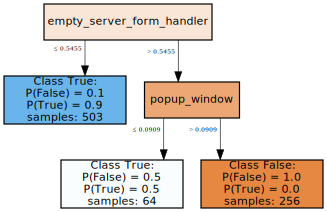

In [61]:
#plot like a tree
#be aware to have graphviz installed on the system
model.draw()

`River`has many implementatrions of the tree but as the authors of the library remember on their page, most of them can be organized in the following table.

| Name | Acronym | Task | Non-stationary data? | Comments | Source |
| :- | :-: | :- | :-: | :- | :-: |
| Hoeffding Tree Classifier | HTC | Classification | No | Basic HT for classification tasks | [[1]](https://dl.acm.org/doi/pdf/10.1145/347090.347107)
| Hoeffding Adaptive Tree Classifier | HATC | Classification | Yes | Modifies HTC by adding an instance of ADWIN to each node to detect and react to drift detection | [[2]](https://link.springer.com/chapter/10.1007/978-3-642-03915-7_22)
| Extremely Fast Decision Tree Classifier | EFDT | Classification | No | Deploys split decisions as soon as possible and periodically revisit decisions and redo them if necessary. Not as fast in practice as the name implies, but it tends to converge faster than HTC to the model generated by a batch DT | [[3]](https://dl.acm.org/doi/abs/10.1145/3219819.3220005)
| Hoeffding Tree Regressor | HTR | Regression | No | Basic HT for regression tasks. It is an adaptation of the [FIRT/FIMT](https://link.springer.com/article/10.1007/s10618-010-0201-y) algorithm that bears some semblance to HTC | [[4]](https://link.springer.com/article/10.1007/s10618-010-0201-y)
| Hoeffding Adaptive Tree Regressor | HATR | Regression | Yes | Modifies HTR by adding an instance of ADWIN to each node to detect and react to drift detection |
| incremental Structured-Output Prediction Tree Regressor| iSOUPT | Multi-target regression | No | Multi-target version of HTR | [[5]](https://link.springer.com/article/10.1007/s10844-017-0462-7)
| Label Combination Hoeffding Tree Classifier | LCHTC | Multi-label classification | No | Creates a numerical code for each combination of the binary labels and uses HTC to learn from this encoded representation. At prediction time, decodes the modified representation to obtain the original label set |  -


As we can see each variant has a very specific target in mind, although they might overlap sometimes.